# Noise Cancelling

**Apply Gaussian and pepper & salt noise to messi and barbara images.**

**A. Correct the damaged images by filtering the dct coefficients.**

**B. Correct the damaged images using wavelet transform. To do this, you can use the thresholding method to transfer values of high band images to zero and reproduce the images.**

### Part A

The following code snippet import required third-party libraries:
+ `cv2` for reading and utilizing image processing functions
+ `numpy` for calculating and considering images as numerical matrixes
+ `matplotlib.pyplot` for showing images in the output
+ `skimage.util` for generating noise
+ `pywt` for using wavelet transform

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
import pywt

In the next few lines, we will load and show messi and barbara images.

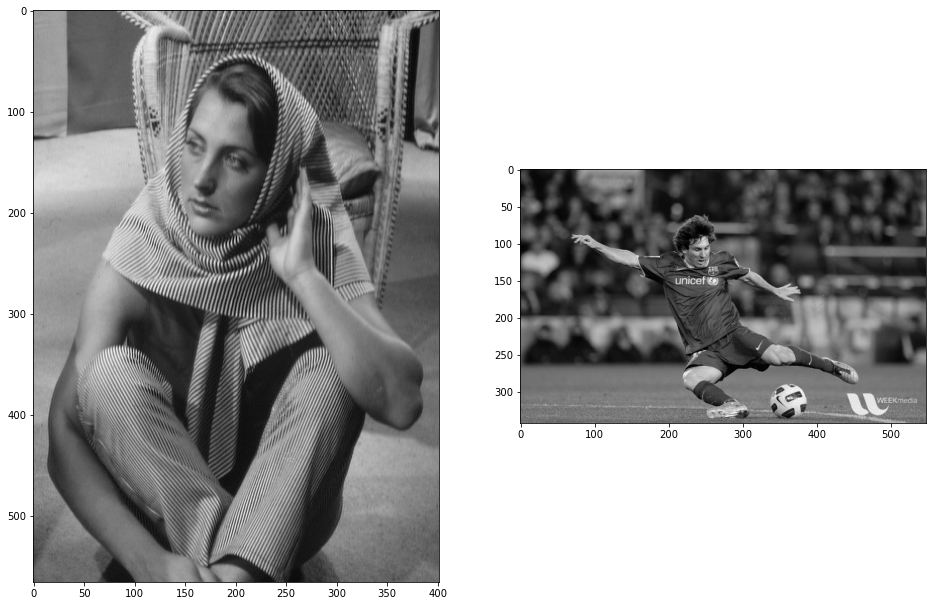

In [2]:
# Reading images in grayscale mode
barbara = cv2.imread("../../images/barbara.tif", cv2.IMREAD_GRAYSCALE)
messi = cv2.imread("../../images/messi5.jpg", cv2.IMREAD_GRAYSCALE)

# Showing the images in subplots
f, subplt = plt.subplots(1, 2, figsize=(16, 14))
subplt[0].imshow(barbara, cmap="gray")
subplt[1].imshow(messi, cmap="gray")
plt.show()

This function calculate PSNR (Peak-to-Noise Ratio) in order to determine the quality of reconstructed versions.

In [3]:
def PSNR(image_1, image_2):
    size = image_1.shape
    # Calculate MSE
    MSE_array = (image_1 - image_2) ** 2
    MSE = MSE_array.sum() / (size[0] * size[1])
    # Calculate PSNR
    PSNR = 10 * np.log(255 ** 2 / MSE)
    return PSNR

The following function apply Gaussian and Salt&Pepper noise to the image.

In [4]:
def apply_noise(image):
    # Adding Gaussian noise
    corrrupted_image = random_noise(image, mode="gaussian", var=0.001, mean=0)
    # Adding salt and pepper noise
    corrrupted_image = random_noise(corrrupted_image, mode="s&p", amount = 0.01)
    return corrrupted_image

We can see corrupted version of messi and barbara images

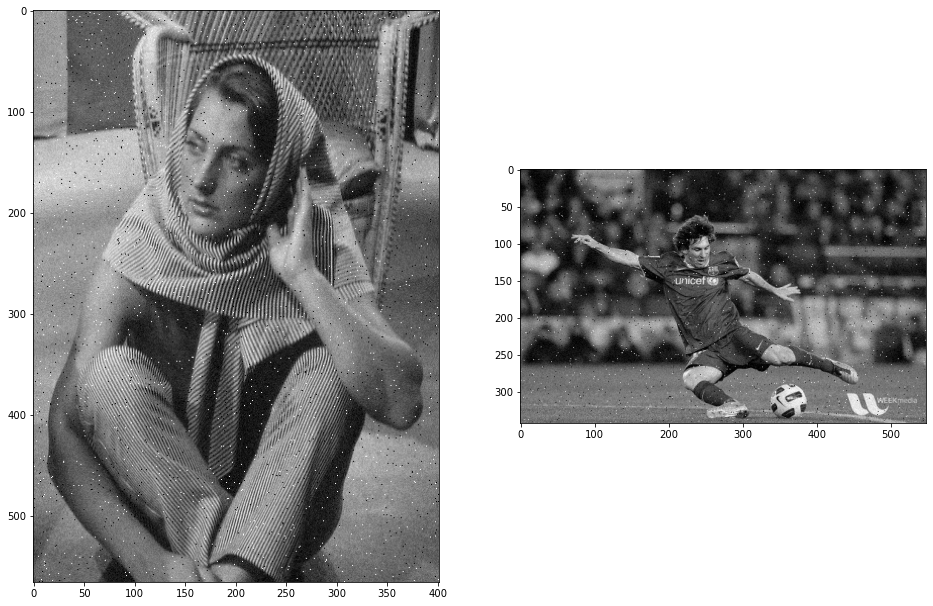

In [5]:
# Showing the images in subplots
barbara_corrupted = apply_noise(barbara)
messi_corrupted = apply_noise(messi)
f, subplt = plt.subplots(1, 2, figsize=(16, 14))
subplt[0].imshow(barbara_corrupted, cmap="gray")
subplt[1].imshow(messi_corrupted, cmap="gray")
plt.show()

Following code snippet contains a function which is written for calculating DCT coefficients, then apply a mask, and apply inverse of DCT. Also you can see the mask that the function apply to the image.

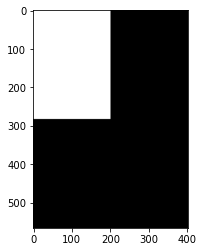

In [10]:
def dct_denoise(image_corrupted): 
    """
    image_corrupted: the noisy image that need to be corrected
    return the corrected version of the image
    """
    # Apply DCT to the image
    image_dct = cv2.dct(np.array(image_corrupted, dtype = np.float32))
    # Create mask for DCT coefficients
    mask = np.zeros(image_dct.shape,dtype=np.float32)
    mask[:mask.shape[0]//2, :mask.shape[1]//2] = 1
    # Apply mask to the image
    filtered_image = image_dct * mask
    # Apply inverse of DCT
    result = cv2.idct(np.array(filtered_image, dtype = np.float32))
    return result

# Showing the used mask
mask = np.zeros(barbara.shape,dtype=np.float32)
mask[:mask.shape[0]//2, :mask.shape[1]//2] = 1

plt.imshow(mask, cmap = 'gray')
plt.show()

Next we will use function above to correct the corrupted image.
PSNR values are shown in the images. As we can see, salt&pepper noise are still visible but it is a bit harder to notice gaussian effect on the image.
Overall, we can say this method is not a good one for correcting these noises.

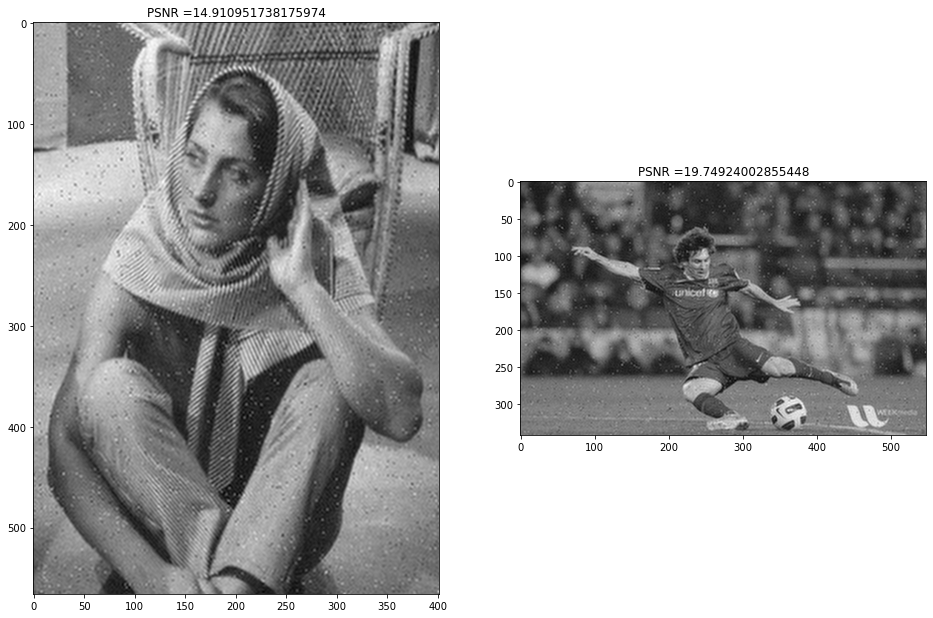

In [7]:
# Showing the images in subplots
barbara_reconstructed = dct_denoise(barbara_corrupted)
messi_reconstructed = dct_denoise(messi_corrupted)
f, subplt = plt.subplots(1, 2, figsize=(16, 14))
subplt[0].imshow(barbara_reconstructed, cmap="gray")
subplt[0].set_title('PSNR =' + str(PSNR(barbara_reconstructed, barbara)))
subplt[1].imshow(messi_reconstructed, cmap="gray")
subplt[1].set_title('PSNR =' + str(PSNR(messi_reconstructed, messi)))
plt.show()

Following code snippet contains a function which is written for calculating Haar wavelet transform, then find applying a filter to the bands and finally apply the inverse of Haar wavelet tranfrom on the result.

In [8]:
def haar_denoise(image):
    """
    image_corrupted: the noisy image that need to be corrected
    return the corrected version of the image 
    """
    # Change the data type of the image
    image = image.astype(np.float32)
    # Calculating bands of Haar wavelet transform
    cA1, (cH1, cV1, cD1) = pywt.dwt2(image, 'haar')
    # Apply High pass filter to the bands
    cH1 = np.where(abs(cH1) < 0.2, 0, cH1)
    cV1 = np.where(abs(cV1) < 0.2, 0, cV1)
    cD1 = np.where(abs(cD1) < 0.8, 0, cD1)
    # Apply inverse of Haar wavelet transform
    reconstructed = pywt.idwt2((cA1, (cH1, cV1, cD1)), 'haar')
    return reconstructed

In the following lines, the function above will be called in order to use Haar wavelet to correct the noisy images. There is a slight growth in the values of their PSNR, but still we can say the noise is gone. Again, we could not say that Haar wavelet transform erase the noises from the images.

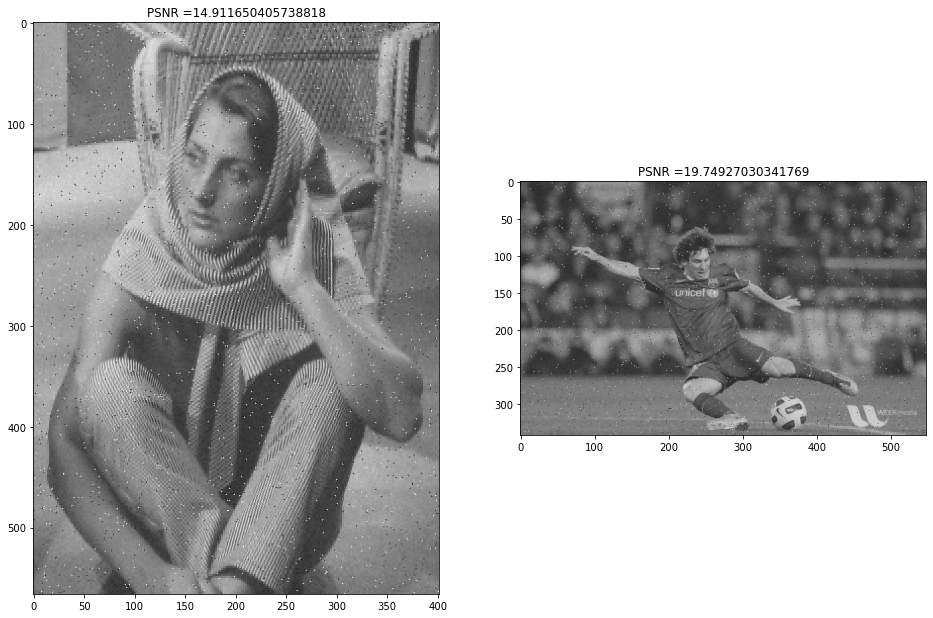

In [9]:
# Showing the image in subplots
barbara_reconstructed = haar_denoise(barbara_corrupted)
messi_reconstructed = haar_denoise(messi_corrupted)
f, subplt = plt.subplots(1, 2, figsize=(16, 14))
subplt[0].imshow(barbara_reconstructed, cmap="gray")
subplt[0].set_title('PSNR =' + str(PSNR(barbara_reconstructed, barbara)))
subplt[1].imshow(messi_reconstructed, cmap="gray")
subplt[1].set_title('PSNR =' + str(PSNR(messi_reconstructed, messi)))
plt.show()

Finally, I could say DCT filtering was more useful because the corrected versions had more contrast and seemed better. If we adjusted the mask, we would get an even better result. So PSNR metric is not very dependable for these images.